## Make a prediction of a district’s median housing price
Main steps:

1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.


## 1. Frame the problem 

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


## 2. Get data

In [2]:
#Load data
house = pd.read_csv("housing.csv")
df = pd.DataFrame(house)

In [3]:
#View Data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


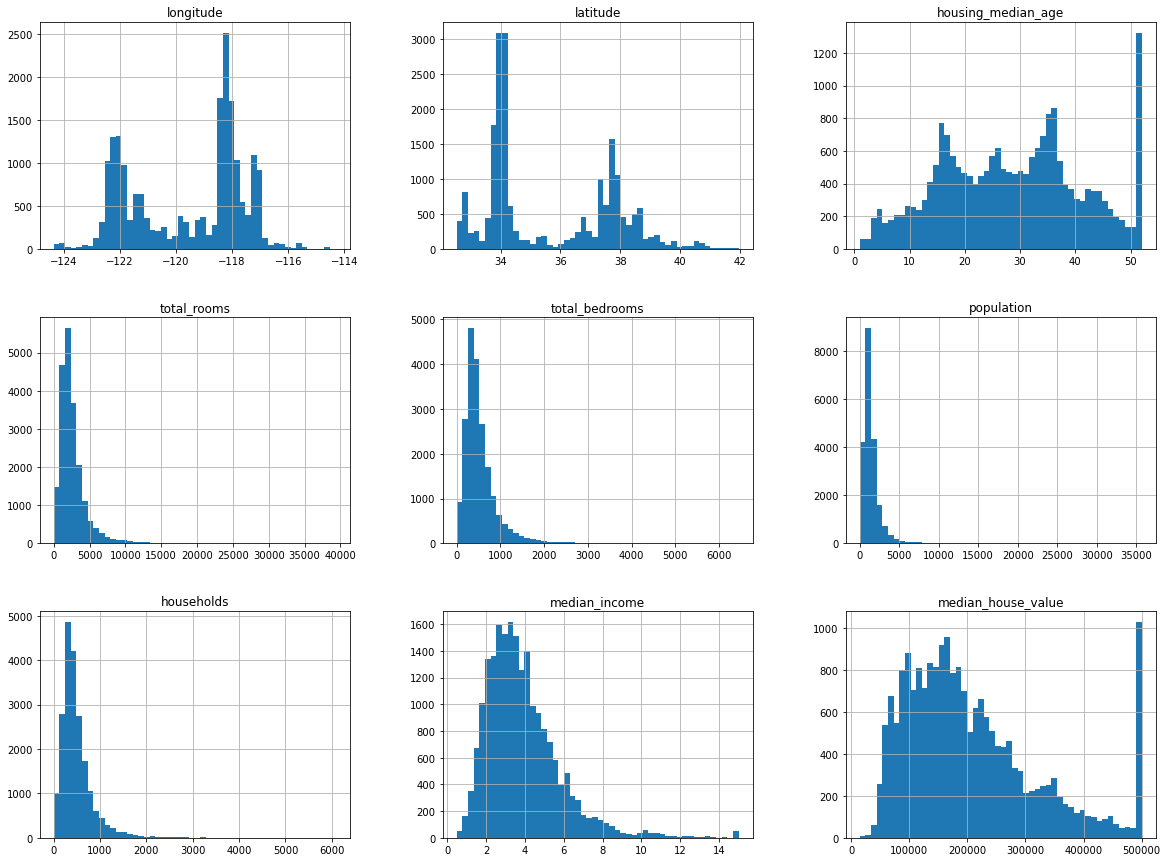

In [7]:
df.hist(bins=50,figsize=(20,15))
plt.show()

### * Measure by RMSE  - cost function: Root Mean Square Error


## Create Test Set

In [8]:
#Pick random instances
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(df,0.2)
len(train_set)

16512

In [10]:
len(test_set)

4128

In [11]:
#make sure you have the same 20% instances
from zlib import crc32

def test_set_check(identifier,test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data,test_ratio,id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_,test_ratio))
    return data.loc[~in_test_set],data.loc[in_test_set]

In [12]:
housing_with_id = df.reset_index()
train_set,test_set = split_train_test_by_id(housing_with_id,0.2,"index")

In [13]:
#A better way, using Scikit-Learn to split data

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
#Categorize data by income
df["income_cat"] = pd.cut(df["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

<AxesSubplot:>

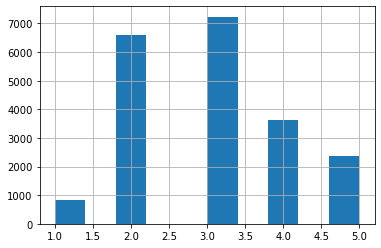

In [15]:
df["income_cat"].hist()

In [16]:
#Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df,df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

#Income catagory proportion
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
#Remove the income_cat, back to original data
for set_ in(strat_test_set,strat_train_set):
    set_.drop("income_cat",axis=1,inplace=True)

## 3. Discover and Visualize the Data to Gain Insights

In [18]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

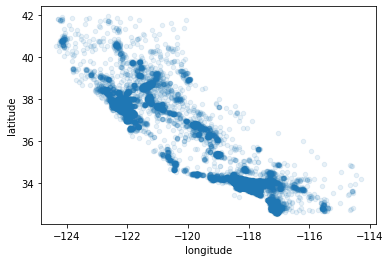

In [19]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha = 0.1)

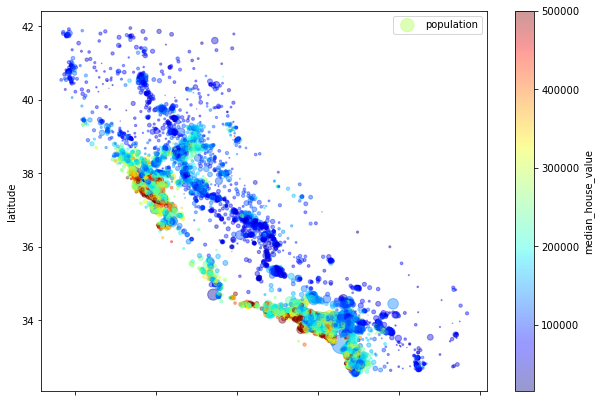

In [20]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
            s=housing["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [21]:
#Correlations
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

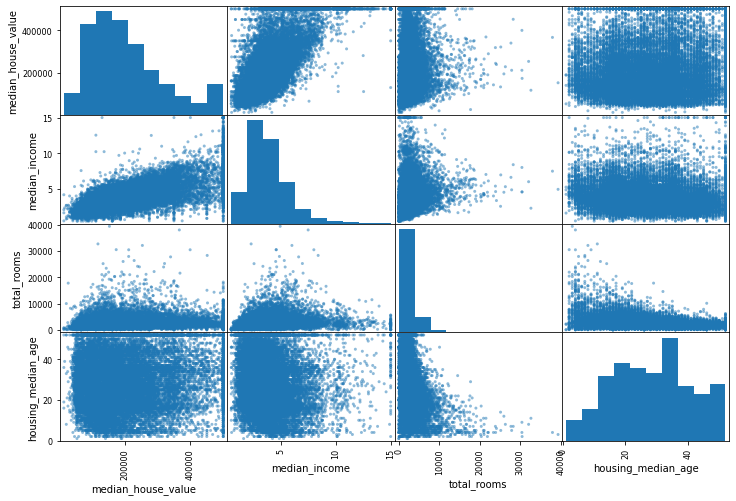

In [22]:
#Plot top 4 correlated with median housing value
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

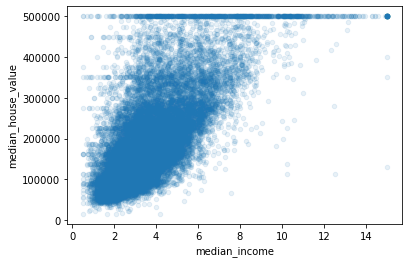

In [23]:
#median income with median house value
df.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

#### Attribute Combinations Experiments

In [24]:
#Number of rooms per household
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

In [25]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

## 4. Prepare the Data for Machine Learning Algorithms

In [26]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [27]:
#drop() creats a copy, doesn't affect 'strat_train_set'
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels =  strat_train_set["median_house_value"].copy()

In [28]:
# #Data cleaning - missing values 
# housing.dropna(subset=["total_bedrooms"]) # dropna()
# housing.drop("total_bedrooms",axis=1) #drop()
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(madian,inplace=True) #fillna() with median

In [29]:
#SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [30]:
#the func can only handle numbers, drop text values
housing_num = housing.drop("ocean_proximity",axis=1)

In [31]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [32]:
#median for each attribute
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [33]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
X = imputer.transform(housing_num) # output is np array

In [35]:
# np array to DataFrame
housing_transformed = pd.DataFrame(X,columns=housing_num.columns)

#### Text and categorical attributes

In [36]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [37]:
#transform text to nums
from sklearn.preprocessing import OrdinalEncoder
ordinal_endcoder = OrdinalEncoder()
housing_cat_encoded = ordinal_endcoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [38]:
ordinal_endcoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [39]:
#transform to 0-1 dummy attribute , type is Scipy-Sparse
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [40]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [41]:
# Custom transformer
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedrooms_ix,population_ix,households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### Transformation Pipelines

In [42]:
#Pipeline for fit_transform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer',SimpleImputer(strategy="median")),
                         ('attribs_adder',CombinedAttributesAdder()),
                          ('std_scalar',StandardScaler())])
housing_num_str = num_pipeline.fit_transform(housing_num)

In [43]:
# a name, a transformer, and a list of column-names
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",OneHotEncoder(),cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## 5. Select and train a model

In [44]:
#Linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [45]:
#test prediction with some data
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prep = full_pipeline.transform(some_data)
print("Predictions: ",lin_reg.predict(some_data_prep))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [46]:
#measured by RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68628.19819848923

Conclusion:
*Lin_reg is underfitting, model is too simple*
*median range is between 120,000 and 265,000, the error is 68,628*

In [47]:
#Desision Tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [48]:
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

##### Cross-Validation

In [49]:
#K-fold cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [50]:
#func to display scores 
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [51]:
display_scores(tree_rmse_scores)

Scores: [68268.01213534 67357.56967511 71576.90660383 69576.92463361
 71122.65659638 75569.96392516 72406.13375936 70747.56557859
 76959.7326636  69720.85866635]
Mean: 71330.63242373188
Standard deviation: 2865.15286282123


In [52]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983507


In [53]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [54]:
housing_predictions_RFR = forest_reg.predict(housing_prepared)
forest_reg = mean_squared_error(housing_labels,housing_predictions_RFR)
forest_rmse = np.sqrt(forest_reg)
forest_rmse

18641.73344527661

In [ ]:
# forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
#                                 scoring="neg_mean_squared_error", cv=10)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

## 6. Fine-Tune The Model

In [57]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [59]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64198.85501944004 {'max_features': 2, 'n_estimators': 3}
54996.16508719244 {'max_features': 2, 'n_estimators': 10}
53170.52686679174 {'max_features': 2, 'n_estimators': 30}
60634.593945593086 {'max_features': 4, 'n_estimators': 3}
53172.52436093039 {'max_features': 4, 'n_estimators': 10}
50719.3425779829 {'max_features': 4, 'n_estimators': 30}
59129.428556311614 {'max_features': 6, 'n_estimators': 3}
51942.97933308888 {'max_features': 6, 'n_estimators': 10}
49737.87344917999 {'max_features': 6, 'n_estimators': 30}
58912.34915992233 {'max_features': 8, 'n_estimators': 3}
52478.16167321205 {'max_features': 8, 'n_estimators': 10}
50008.84789062577 {'max_features': 8, 'n_estimators': 30}
63066.43109193817 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54414.700199957384 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59719.758316793326 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52351.58968774124 {'bootstrap': False, 'max_features': 3, 'n_estimators':

#### Analyze the model and evaluate

In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.17309631e-02, 7.12119693e-02, 4.20880895e-02, 1.80303295e-02,
       1.68275459e-02, 1.66184530e-02, 1.59897289e-02, 3.05869173e-01,
       7.56668838e-02, 1.12134615e-01, 7.79972086e-02, 1.38573982e-02,
       1.54113152e-01, 6.59385382e-05, 3.01886675e-03, 4.77968564e-03])

In [64]:
#attributes with impotance scores
extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,attributes),reverse=True)

[(0.30586917267859537, 'median_income'),
 (0.15411315165304088, 'INLAND'),
 (0.11213461500327969, 'pop_per_hhold'),
 (0.07799720864005384, 'bedrooms_per_room'),
 (0.07566688376383239, 'rooms_per_hhold'),
 (0.07173096313197552, 'longitude'),
 (0.07121196926775226, 'latitude'),
 (0.04208808952293174, 'housing_median_age'),
 (0.01803032945434989, 'total_rooms'),
 (0.01682754588233442, 'total_bedrooms'),
 (0.01661845300911167, 'population'),
 (0.01598972889926066, 'households'),
 (0.013857398169236184, '<1H OCEAN'),
 (0.004779685639957267, 'NEAR OCEAN'),
 (0.003018866746079008, 'NEAR BAY'),
 (6.593853820913788e-05, 'ISLAND')]

In [65]:
# Test Set evaluation
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [66]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46673.66926083, 50584.47728741])